# Adversarial Autoencoders with the CIFAR-10 Dataset
See http://arxiv.org/pdf/1511.05644v1.pdf

In [1]:
import numpy as np
import sys
import tensorflow as tf
import time

import load_cifar10
import ops

%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
from matplotlib import cm

FLOAT = tf.float32

## Load in the dataset and take a gander

In [2]:
batches = load_cifar10.Batches()
train_batches = batches[:5]
train_images = np.concatenate(train_batches)
test_batch = batches[5]

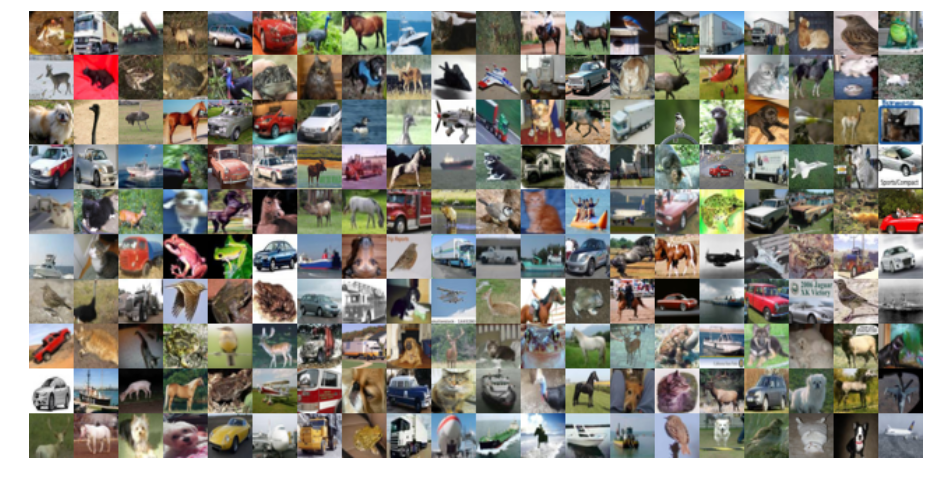

In [3]:
figsize(16, 8)
plt.imshow(
    np.concatenate(
        [np.concatenate(list(train_images[i * 20:(i + 1) * 20]), axis=1)
         for i in xrange(10)]))
plt.axis("off")
plt.show()

In [4]:
try:
    del(sess)
    print "deleted session"
except Exception as e:
    print "no existing session to delete"
sess = tf.InteractiveSession()

no existing session to delete


### Simple Autoencoder

In [43]:


class SimpleAutoencoder(object):
    
    def __init__(
            self, sess,
            first_hidden_layer_size=1024,
            encoding_steps=2,
            name="SimpleAutoencoder"):
        self.sess = sess
        self.first_hidden_layer_size = first_hidden_layer_size
        self.encoding_steps = encoding_steps
        self.name = name
        
        # Book keeping
        self.training_examples_seen = 0
        self.train_error_history = []
        self.test_error_history = []

        # Initialization
        self.BuildNet()
        self.sess.run(tf.initialize_all_variables())

    def BuildNet(self):
        with tf.name_scope(self.name) as ns:
            self.inputs = tf.placeholder(tf.float32, [None, 32, 32, 3], name="Inputs")
            flattened = tf.reshape(self.inputs, [-1, 32 * 32 * 3], name="Flatten")

            # Encoding
            layer_sizes = (
                [int(flattened.get_shape()[-1])] +
                [self.first_hidden_layer_size / (2 ** x) for x in xrange(self.encoding_steps)])
            layers = [flattened]
            for x in xrange(self.encoding_steps):
                _, _, enc_layer = ops.HiddenLayer(
                    layers[-1],
                    [layer_sizes[x], layer_sizes[x + 1]],
                    nonlin=tf.nn.relu,
                    scope="Enc{}".format(x))
                layers.append(enc_layer)
            self.z = layers[-1]
            
            # Decoding
            for x in reversed(xrange(self.encoding_steps)):
                _, _, dec_layer = ops.HiddenLayer(
                    layers[-1],
                    [layer_sizes[x + 1], layer_sizes[x]],
                    nonlin=tf.nn.sigmoid if x == 0 else tf.nn.relu,
                    scope="Dec{}".format(x))
                layers.append(dec_layer)
            self.outputs = tf.reshape(layers[-1], [-1, 32, 32, 3])

            # Error and Training
            self.error = tf.sqrt(tf.reduce_mean(tf.square(self.outputs - self.inputs)))
            self.learn_rate = tf.placeholder(tf.float32, name="LearnRate")
            self.train_step = tf.train.AdamOptimizer(self.learn_rate).minimize(self.error)

    def Test(self, test_images):
        (err,) = self.sess.run([self.error], feed_dict={self.inputs: test_images})
        self.test_error_history.append((self.training_examples_seen, err))

    def ReportTestError(self):
        print "\nAfter {tes} training examples, test error = {e:.5f}".format(
            tes=self.training_examples_seen,
            e=self.test_error_history[-1][-1])

    def ReportTrainError(self):
        print "After {tes} training examples, training error = {e:.5f}".format(
            tes=self.training_examples_seen,
            e=self.train_error_history[-1][-1])
  
    def TrainingEpoch(self, train_images, batch_size, learn_rate, report_every_n_batches):
        batches_per_epoch = len(train_images) / batch_size
        np.random.shuffle(train_images)
        for batch in xrange(batches_per_epoch):
            start_offset = batch * batch_size
            stop_offset = start_offset + batch_size
            _, err = self.sess.run(
                [self.train_step, self.error],
                feed_dict={
                    self.inputs: train_images[start_offset:stop_offset],
                    self.learn_rate: learn_rate})
            self.training_examples_seen += batch_size
            self.train_error_history.append((self.training_examples_seen, err))
            if (batch + 1) % report_every_n_batches == 0:
                self.ReportTrainError()

    def ShowExamples(self, images):
        try:
            figsize(16, 2)
        except:
            pass
        (reconst,) = self.sess.run([self.outputs], feed_dict={self.inputs: images})
        plt.imshow(
            np.concatenate(
                [np.concatenate(list(images), axis=1),
                 np.concatenate(list(reconst), axis=1)]))
        plt.axis("off")
        plt.show()

    def Train(
            self, train_images, test_images,
            batch_size, learn_rate, epochs,
            report_every_n_batches, show_examples):
        self.Test(test_images)
        self.ReportTestError()
        for ep in xrange(epochs):
            print "\nStarting Training Epoch {}".format(ep)
            self.TrainingEpoch(train_images, batch_size, learn_rate, report_every_n_batches)
            self.Test(test_images)
            self.ReportTestError()
            if show_examples:
                self.ShowExamples(test_images[:16])

In [46]:
sa = SimpleAutoencoder(sess, encoding_steps=1, first_hidden_layer_size=1024)


After 0 training examples, test error = 0.25634

Starting Training Epoch 0
After 10000 training examples, training error = 0.18361
After 20000 training examples, training error = 0.15990
After 30000 training examples, training error = 0.14578
After 40000 training examples, training error = 0.14320
After 50000 training examples, training error = 0.13316

After 50000 training examples, test error = 0.13315


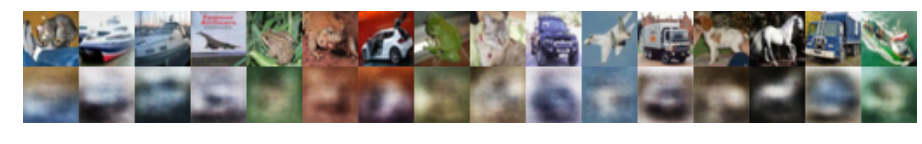


Starting Training Epoch 1
After 60000 training examples, training error = 0.12580
After 70000 training examples, training error = 0.12310
After 80000 training examples, training error = 0.11695
After 90000 training examples, training error = 0.12526
After 100000 training examples, training error = 0.11919

After 100000 training examples, test error = 0.10952


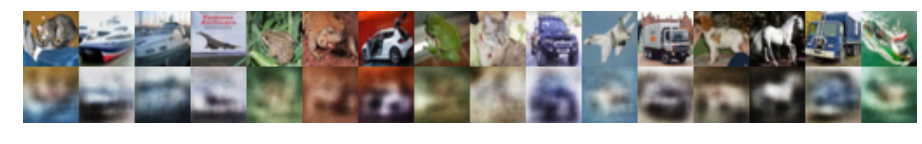


Starting Training Epoch 2
After 110000 training examples, training error = 0.12548
After 120000 training examples, training error = 0.10945
After 130000 training examples, training error = 0.11407
After 140000 training examples, training error = 0.10046
After 150000 training examples, training error = 0.09961

After 150000 training examples, test error = 0.10187


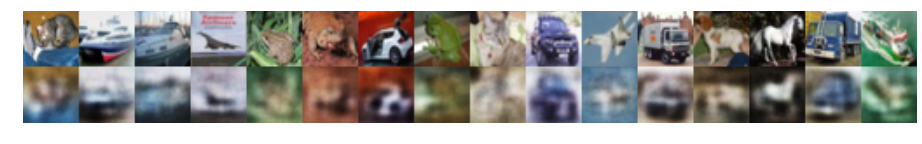


Starting Training Epoch 3
After 160000 training examples, training error = 0.10320
After 170000 training examples, training error = 0.10225
After 180000 training examples, training error = 0.10968
After 190000 training examples, training error = 0.09168
After 200000 training examples, training error = 0.09158

After 200000 training examples, test error = 0.09309


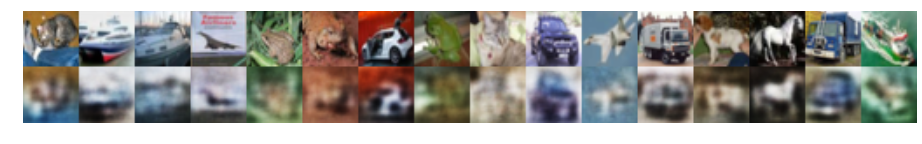


Starting Training Epoch 4
After 210000 training examples, training error = 0.09163
After 220000 training examples, training error = 0.08865
After 230000 training examples, training error = 0.09283
After 240000 training examples, training error = 0.09395
After 250000 training examples, training error = 0.10059

After 250000 training examples, test error = 0.09256


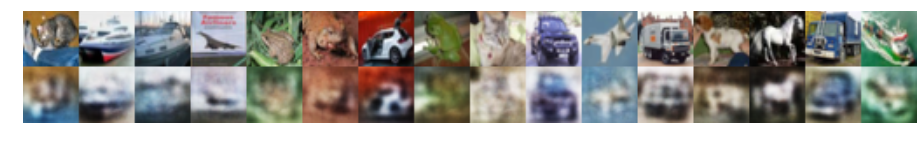


Starting Training Epoch 5
After 260000 training examples, training error = 0.08667
After 270000 training examples, training error = 0.08765
After 280000 training examples, training error = 0.09136
After 290000 training examples, training error = 0.08446
After 300000 training examples, training error = 0.08757

After 300000 training examples, test error = 0.08689


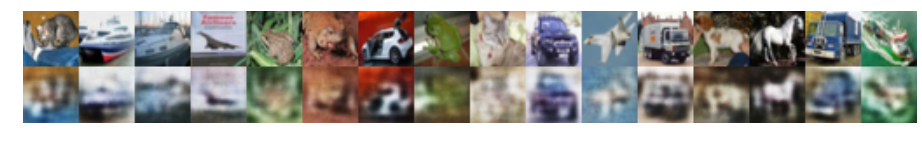


Starting Training Epoch 6
After 310000 training examples, training error = 0.08039
After 320000 training examples, training error = 0.08376
After 330000 training examples, training error = 0.09104
After 340000 training examples, training error = 0.08266
After 350000 training examples, training error = 0.08687

After 350000 training examples, test error = 0.08631


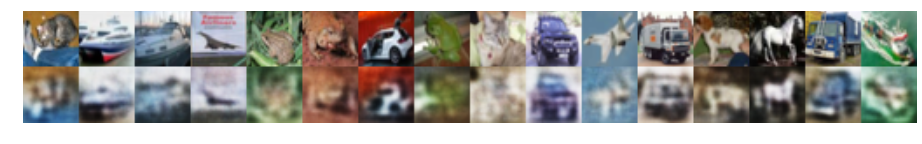


Starting Training Epoch 7
After 360000 training examples, training error = 0.08044
After 370000 training examples, training error = 0.08030
After 380000 training examples, training error = 0.08295
After 390000 training examples, training error = 0.08012
After 400000 training examples, training error = 0.08575

After 400000 training examples, test error = 0.08363


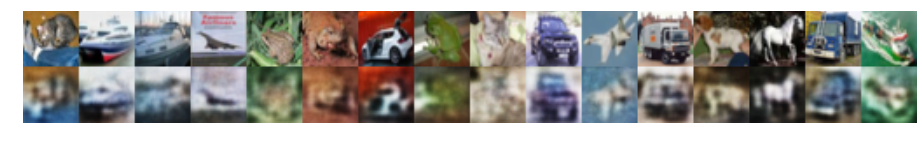


Starting Training Epoch 8
After 410000 training examples, training error = 0.07890
After 420000 training examples, training error = 0.08386
After 430000 training examples, training error = 0.08322
After 440000 training examples, training error = 0.08475
After 450000 training examples, training error = 0.07848

After 450000 training examples, test error = 0.08044


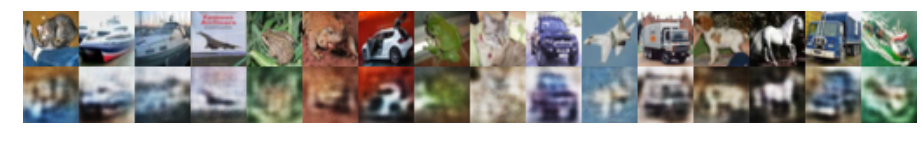


Starting Training Epoch 9
After 460000 training examples, training error = 0.07701
After 470000 training examples, training error = 0.07862
After 480000 training examples, training error = 0.07681
After 490000 training examples, training error = 0.08217
After 500000 training examples, training error = 0.08099

After 500000 training examples, test error = 0.08014


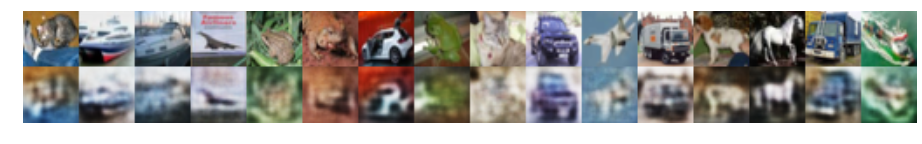

In [47]:
sa.Train(
    train_images=train_images,
    test_images=test_batch[:100],
    batch_size=100,
    learn_rate=0.001,
    epochs=10,
    report_every_n_batches=100,
    show_examples=True)